<a href="https://colab.research.google.com/github/siddharthrayy/House-Price-Prediction-/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU xgboost
!pip install -qU lightgbm

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import norm, skew
import os

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler

plt.style.use("fivethirtyeight")
pd.pandas.set_option('display.max_columns', None)
sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [ ]:
test['Id'].values

array([1461, 1462, 1463, ..., 2917, 2918, 2919])

In [ ]:
train.drop(['Id'], axis=1, inplace=True)

test_id = test['Id'].values 
test.drop(['Id'], axis=1, inplace=True)

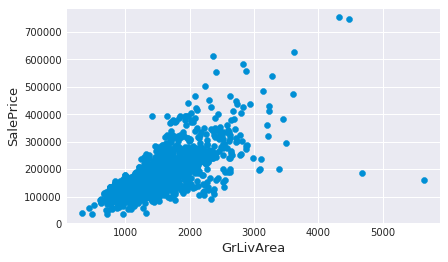

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

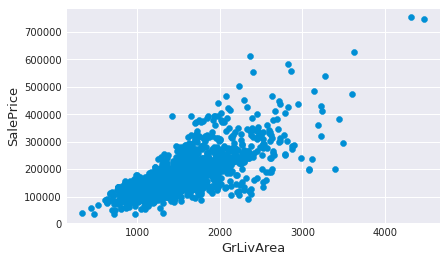

In [ ]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

<ipython-input-10-2c067726f2de>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'] , fit=norm);


mu = 180932.92 and sigma = 79467.79


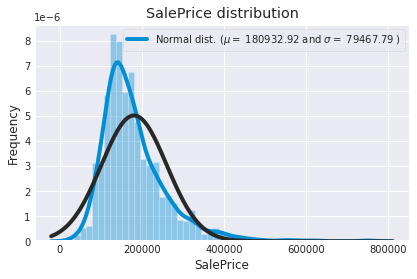

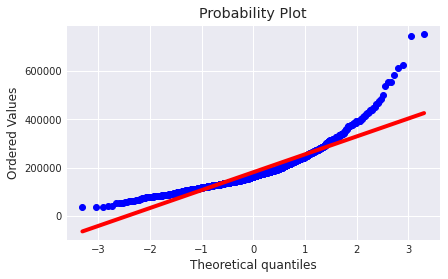

In [ ]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

#Now plot the distribution
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

<ipython-input-11-ff6e86b16e68>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'] , fit=norm);


mu = 12.02 and sigma = 0.40


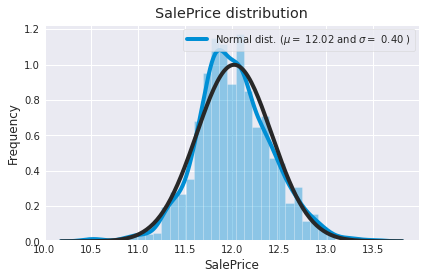

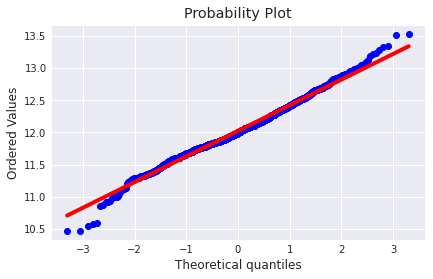

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

#Now plot the distribution
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

<ipython-input-12-ff6e86b16e68>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'] , fit=norm);


mu = 2.57 and sigma = 0.03


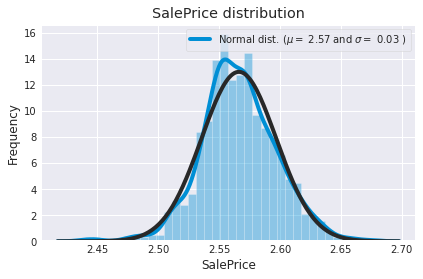

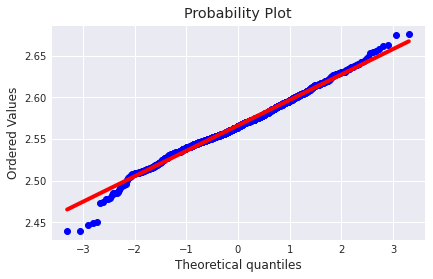

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

#Now plot the distribution
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print(f"all_data size is : {all_data.shape}")

all_data size is : (2917, 79)


In [ ]:
features_with_na = {feature: all_data[feature].isnull().sum() for feature in all_data.columns 
                    if all_data[feature].isnull().sum() > 0}

size = all_data.shape[0]
a = pd.DataFrame({
    'features': list(features_with_na.keys()),
    'Total': list(features_with_na.values()),
    'Missing_PCT': [np.round((features_with_na[i] / size) * 100, 3) for i in features_with_na.keys()]
}).sort_values(by='Missing_PCT', ascending=False).reset_index(drop=True)
a.style.background_gradient(cmap='Reds') 

,features,Total,Missing_PCT
0,PoolQC,2908,99.691000
1,MiscFeature,2812,96.400000
2,Alley,2719,93.212000
3,Fence,2346,80.425000
4,FireplaceQu,1420,48.680000
5,LotFrontage,486,16.661000
6,GarageFinish,159,5.451000
7,GarageQual,159,5.451000
8,GarageCond,159,5.451000
9,GarageYrBlt,159,5.451000


In [ ]:
print(f"Total number of missing values: {all_data.isna().sum().sum()}")

Total number of missing values: 13958


In [ ]:
num_with_nan = [feature for feature in features_with_na.keys() if train[feature].dtypes != 'O']
pd.DataFrame({
    'feature': num_with_nan,
    'Count': [all_data[i].isna().sum() for i in num_with_nan]
})

,feature,Count
0,LotFrontage,486
1,MasVnrArea,23
2,BsmtFinSF1,1
3,BsmtFinSF2,1
4,BsmtUnfSF,1
5,TotalBsmtSF,1
6,BsmtFullBath,2
7,BsmtHalfBath,2
8,GarageYrBlt,159
9,GarageCars,1


In [ ]:

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].apply(
    lambda x: x.fillna(x.median()))
all_data["LotFrontage"].isna().sum()

0

In [ ]:
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data["MasVnrArea"].isna().sum()

0

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

all_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
         'BsmtFullBath', 'BsmtHalfBath']].isna().sum()

BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

In [ ]:

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

all_data[['GarageYrBlt', 'GarageArea', 'GarageCars']].isna().sum()

GarageYrBlt    0
GarageArea     0
GarageCars     0
dtype: int64

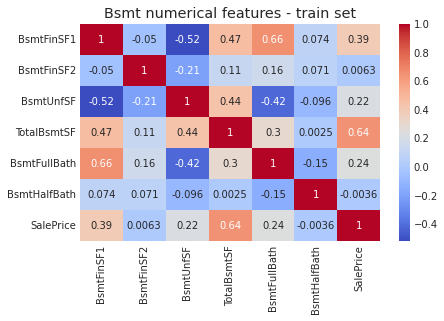

In [ ]:
sns.heatmap(pd.DataFrame(
    {
        'BsmtFinSF1': train['BsmtFinSF1'],
        'BsmtFinSF2': train['BsmtFinSF2'], 
        'BsmtUnfSF': train['BsmtUnfSF'],
        'TotalBsmtSF': train['TotalBsmtSF'], 
        'BsmtFullBath': train['BsmtFullBath'], 
        'BsmtHalfBath': train['BsmtHalfBath'],
        'SalePrice': train['SalePrice'],
    }
).corr(), cmap='coolwarm', annot=True) 
plt.title("Bsmt numerical features - train set")
plt.show()

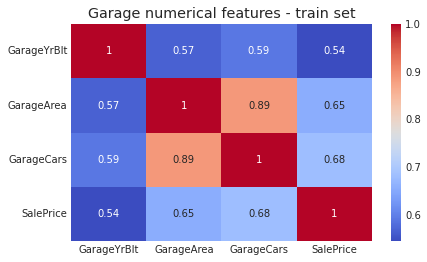

In [ ]:
sns.heatmap(pd.DataFrame(
    {
        'GarageYrBlt': train['GarageYrBlt'], 
        'GarageArea': train['GarageArea'],
        'GarageCars': train['GarageCars'],
        'SalePrice': train['SalePrice'],
    }).corr(), annot=True, cmap='coolwarm'
)
plt.title("Garage numerical features - train set")
plt.show()

In [ ]:
to_remove_ = ['BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 
             'GarageYrBlt', 'GarageArea']

In [ ]:
all_data[num_with_nan].isna().sum()

LotFrontage     0
MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64

In [ ]:
cat_nan = [feature for feature in features_with_na if all_data[feature].dtypes == "O"]
pd.DataFrame({
    'feature': cat_nan,
    'Count': [all_data[i].isna().sum() for i in cat_nan]
}).sort_values(by="Count", ascending = False).reset_index(drop=True)

,feature,Count
0,PoolQC,2908
1,MiscFeature,2812
2,Alley,2719
3,Fence,2346
4,FireplaceQu,1420
5,GarageQual,159
6,GarageFinish,159
7,GarageCond,159
8,GarageType,157
9,BsmtCond,82


In [ ]:
to_remove_.extend(['PoolQC','MiscFeature','Alley','Fence', 'Utilities'])

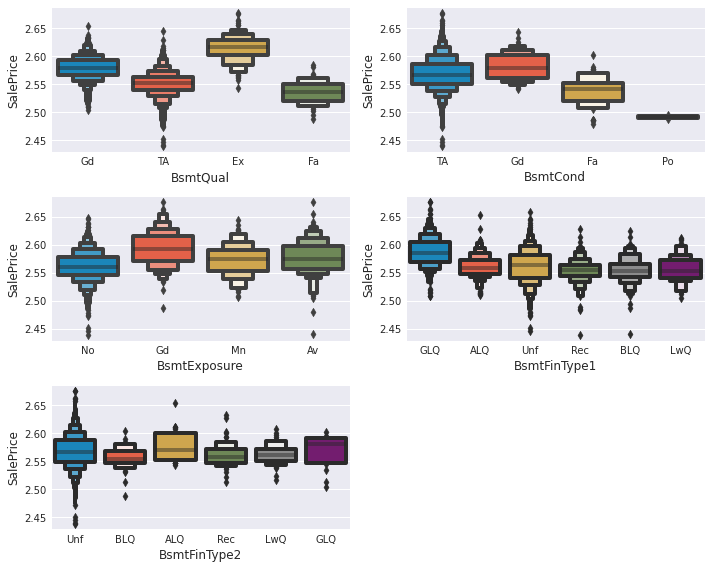

In [ ]:
plt.figure(figsize=(10, 8))
basement_variables = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 
                      'BsmtFinType1', 'BsmtFinType2']

for i, feature in enumerate(basement_variables, 1):
    plt.subplot(3, 2, i)
    sns.boxenplot(data=train, x=feature, y=train['SalePrice'])

plt.tight_layout(h_pad=1.2)
plt.show()

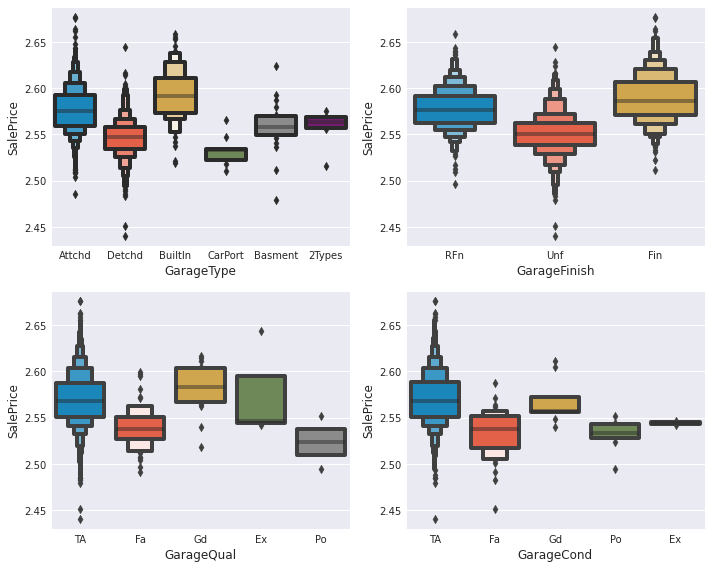

In [ ]:
plt.figure(figsize=(10, 8))
garage_variables = ['GarageType', 'GarageFinish', 'GarageQual', 
                    'GarageCond']

for i, feature in enumerate(garage_variables, 1):
    plt.subplot(2, 2, i)
    sns.boxenplot(data=train, x=feature, y=train['SalePrice'])

plt.tight_layout(h_pad=1.2)
plt.show()

In [ ]:
fill_none = ["FireplaceQu",  "GarageType", "GarageFinish", "GarageQual", "GarageCond", 
             "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MasVnrType"]

for feature in fill_none:
    all_data[feature].fillna("None", inplace=True)

all_data[fill_none].isna().sum().sum()

0

In [ ]:
fill_none = ["FireplaceQu",  "GarageType", "GarageFinish", "GarageQual", "GarageCond", 
             "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "MasVnrType"]

for feature in fill_none:
    all_data[feature].fillna("None", inplace=True)

all_data[fill_none].isna().sum().sum()

0

In [ ]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [ ]:
print(f"Number of missing values: {all_data.isna().sum().sum()}")

Number of missing values: 10796


In [ ]:
all_data.drop(to_remove_, axis=1, inplace=True)
all_data.shape

(2917, 68)

In [ ]:
all_data_cat = all_data.copy()
all_data_cat.shape

(2917, 68)

In [ ]:
all_data_free = all_data.copy()
remove_cat_garage_bsmt = ["GarageType", "GarageFinish", "GarageQual", "GarageCond", 
             "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
all_data_free.drop(remove_cat_garage_bsmt, axis=1, inplace=True)
all_data_free.shape

(2917, 59)

In [ ]:

all_data_cat['MSSubClass'] = all_data_cat['MSSubClass'].apply(str)



all_data_cat['OverallCond'] = all_data_cat['OverallCond'].astype(str)



all_data_cat['YrSold'] = all_data_cat['YrSold'].astype(str)
all_data_cat['MoSold'] = all_data_cat['MoSold'].astype(str)


all_data_free['MSSubClass'] = all_data_free['MSSubClass'].apply(str)
all_data_free['OverallCond'] = all_data_free['OverallCond'].astype(str)


all_data_free['YrSold'] = all_data_free['YrSold'].astype(str)
all_data_free['MoSold'] = all_data_free['MoSold'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder


cols = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 
        'CentralAir', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Functional', 
        'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual', 
        'LandSlope', 'LotShape', 'MSSubClass', 'MoSold', 'OverallCond', 'PavedDrive', 
         'Street', 'YrSold']

for feature in cols:
    encoder = LabelEncoder()
    encoder.fit(all_data_cat[feature].values)
    all_data_cat[feature] = encoder.transform(all_data_cat[feature].values)


print(f'Shape all_data_cat: {all_data_cat.shape}')



cols = ['CentralAir', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Functional', 
        'HeatingQC', 'KitchenQual', 'LandSlope', 'LotShape', 'MSSubClass', 
        'MoSold', 'OverallCond', 'PavedDrive', 'Street', 'YrSold']

for feature in cols:
    encoder = LabelEncoder()
    encoder.fit(all_data_free[feature].values)
    all_data_free[feature] = encoder.transform(all_data_free[feature].values)



print(f'Shape all_data_free: {all_data_free.shape}')

Shape all_data_cat: (2917, 68)
Shape all_data_free: (2917, 59)


In [ ]:
all_data_cat['TotalSF'] = all_data_cat['TotalBsmtSF'] + all_data_cat['1stFlrSF'] + all_data_cat['2ndFlrSF']

all_data_free['TotalSF'] = all_data_free['TotalBsmtSF'] + all_data_free['1stFlrSF'] + all_data_free['2ndFlrSF']

In [ ]:
numeric_feature_cat = all_data_cat.select_dtypes("number").columns


skewed_feats_cat = all_data_cat[numeric_feature_cat].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness_cat = pd.DataFrame({'Skew' :skewed_feats_cat})
skewness_cat.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
EnclosedPorch,4.002344
ScreenPorch,3.945101
MasVnrArea,2.621719


In [ ]:
numeric_feature_free = all_data_free.select_dtypes("number").columns

# Check the skew of all numerical features
skewed_feats_free = all_data_free[numeric_feature_free].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness_free = pd.DataFrame({'Skew' :skewed_feats_free})
skewness_free.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
EnclosedPorch,4.002344
ScreenPorch,3.945101
MasVnrArea,2.621719


In [ ]:
from scipy.special import boxcox1p

skewness_cat = skewness_cat[abs(skewness_cat) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness_cat.shape[0]))

skewed_features_cat = skewness_cat.index
lam = 0.15
for feat in skewed_features_cat:
    all_data_cat[feat] = boxcox1p(all_data_cat[feat], lam)

There are 50 skewed numerical features to Box Cox transform


In [ ]:
skewness_free = skewness_free[abs(skewness_free) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness_free.shape[0]))

skewed_features_free = skewness_free.index
lam = 0.15
for feat in skewed_features_free:
    
    all_data_free[feat] = boxcox1p(all_data_free[feat], lam)

There are 42 skewed numerical features to Box Cox transform


In [ ]:
print(f"all_data_cat.shape: {all_data_cat.shape}")
print(f"all_data_free.shape: {all_data_free.shape}")

all_data_cat.shape: (2917, 69)
all_data_free.shape: (2917, 60)


In [ ]:
all_data_free.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,2.885846,RL,5.831328,19.212182,0.730463,1.540963,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,2.440268,1.820334,14.187527,14.187527,Gable,CompShg,VinylSd,VinylSd,BrkFace,8.059126,1.194318,1.820334,PConc,11.170327,11.692623,GasA,0.000000,0.730463,SBrkr,11.692623,11.686189,0.0,13.698888,1.194318,0.730463,1.540963,0.730463,1.194318,2.602594,2.259674,0.000000,1.540963,1.194318,1.194318,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,1.820334,1.194318,WD,Normal,14.976591
1,2.055642,RL,6.221214,19.712205,0.730463,1.540963,Lvl,FR2,0.0,Veenker,Feedr,Norm,1Fam,1Story,2.259674,2.440268,14.145138,14.145138,Gable,CompShg,MetalSd,MetalSd,None,0.000000,1.540963,1.820334,CBlock,12.062832,12.792276,GasA,0.000000,0.730463,SBrkr,12.792276,0.000000,0.0,12.792276,1.194318,0.000000,1.540963,0.730463,1.540963,2.259674,2.259674,0.730463,2.055642,1.194318,1.194318,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,2.440268,0.730463,WD,Normal,14.923100
2,2.885846,RL,5.914940,20.347241,0.730463,0.000000,Lvl,Inside,0.0,CollgCr,Norm,Norm,1Fam,2Story,2.440268,1.820334,14.184404,14.185966,Gable,CompShg,VinylSd,VinylSd,BrkFace,7.646538,1.194318,1.820334,PConc,10.200343,11.892039,GasA,0.000000,0.730463,SBrkr,11.892039,11.724598,0.0,13.832085,1.194318,0.730463,1.540963,0.730463,1.194318,2.259674,2.259674,0.730463,2.055642,1.194318,1.194318,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,3.011340,1.194318,WD,Normal,15.149678
3,3.011340,RL,5.684507,19.691553,0.730463,0.000000,Lvl,Corner,0.0,Crawfor,Norm,Norm,1Fam,2Story,2.440268,1.820334,14.047529,14.135652,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,1.540963,1.820334,BrkTil,8.274266,11.354094,GasA,1.194318,0.730463,SBrkr,12.013683,11.354094,0.0,13.711364,0.730463,0.000000,1.540963,0.730463,1.194318,2.440268,2.259674,0.730463,1.194318,1.540963,1.194318,0.000000,4.745132,8.797736,0.0,0.0,0.0,0.0,1.820334,0.000000,WD,Abnorml,14.857121
4,2.885846,RL,6.314735,21.325160,0.730463,0.000000,Lvl,FR2,0.0,NoRidge,Norm,Norm,1Fam,2Story,2.602594,1.820334,14.182841,14.182841,Gable,CompShg,VinylSd,VinylSd,BrkFace,9.391827,1.194318,1.820334,PConc,10.971129,12.510588,GasA,0.000000,0.730463,SBrkr,12.510588,12.271365,0.0,14.480029,1.194318,0.730463,1.820334,0.730463,1.194318,2.750250,2.259674,0.730463,2.055642,1.540963,1.194318,8.013884,6.314735,0.000000,0.0,0.0,0.0,0.0,1.540963,1.194318,WD,Normal,15.852312


In [ ]:
all_data_cat = pd.get_dummies(all_data_cat)
print(all_data_cat.shape)

(2917, 206)


In [ ]:
all_data_free = pd.get_dummies(all_data_free)
print(all_data_free.shape)

(2917, 191)


In [ ]:
all_data_free[numeric_feature_free].head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtFinSF1,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalSF
0,2.885846,5.831328,19.212182,0.730463,1.540963,0.0,2.440268,1.820334,14.187527,14.187527,8.059126,1.194318,1.820334,11.170327,11.692623,0.000000,0.730463,11.692623,11.686189,0.0,13.698888,1.194318,0.730463,1.540963,0.730463,1.194318,2.602594,2.259674,0.000000,1.540963,1.194318,1.194318,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,1.820334,1.194318,14.976591
1,2.055642,6.221214,19.712205,0.730463,1.540963,0.0,2.259674,2.440268,14.145138,14.145138,0.000000,1.540963,1.820334,12.062832,12.792276,0.000000,0.730463,12.792276,0.000000,0.0,12.792276,1.194318,0.000000,1.540963,0.730463,1.540963,2.259674,2.259674,0.730463,2.055642,1.194318,1.194318,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,2.440268,0.730463,14.923100
2,2.885846,5.914940,20.347241,0.730463,0.000000,0.0,2.440268,1.820334,14.184404,14.185966,7.646538,1.194318,1.820334,10.200343,11.892039,0.000000,0.730463,11.892039,11.724598,0.0,13.832085,1.194318,0.730463,1.540963,0.730463,1.194318,2.259674,2.259674,0.730463,2.055642,1.194318,1.194318,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,3.011340,1.194318,15.149678
3,3.011340,5.684507,19.691553,0.730463,0.000000,0.0,2.440268,1.820334,14.047529,14.135652,0.000000,1.540963,1.820334,8.274266,11.354094,1.194318,0.730463,12.013683,11.354094,0.0,13.711364,0.730463,0.000000,1.540963,0.730463,1.194318,2.440268,2.259674,0.730463,1.194318,1.540963,1.194318,0.000000,4.745132,8.797736,0.0,0.0,0.0,0.0,1.820334,0.000000,14.857121
4,2.885846,6.314735,21.325160,0.730463,0.000000,0.0,2.602594,1.820334,14.182841,14.182841,9.391827,1.194318,1.820334,10.971129,12.510588,0.000000,0.730463,12.510588,12.271365,0.0,14.480029,1.194318,0.730463,1.820334,0.730463,1.194318,2.750250,2.259674,0.730463,2.055642,1.540963,1.194318,8.013884,6.314735,0.000000,0.0,0.0,0.0,0.0,1.540963,1.194318,15.852312


In [ ]:
train_cat = all_data_cat[:ntrain]
test_cat = all_data_cat[ntrain:]

In [ ]:
train_free = all_data_free[:ntrain]
test_free = all_data_free[ntrain:]

In [ ]:
train_cat.shape, test_cat.shape

((1458, 206), (1459, 206))

In [ ]:
train_free.shape, test_free.shape

((1458, 191), (1459, 191))

In [ ]:
X_cat = train_cat.copy()
cols_cat = X_cat.columns

scaler_cat = MinMaxScaler()

# fitting MinaMaxScaler to training data
scaler_cat.fit(X_cat)

# transforming training and test data
X_cat = scaler_cat.transform(X_cat)
test_cat = scaler_cat.transform(test_cat)


X_cat = pd.DataFrame(X_cat, columns=[cols_cat])
test_cat = pd.DataFrame(test_cat, columns=[cols_cat])
X_cat.shape, test_cat.shape

((1458, 206), (1459, 206))

In [ ]:
X_free = train_free.copy()
cols_free = X_free.columns

scaler_free = MinMaxScaler()

# fitting MinaMaxScaler to training data
scaler_free.fit(X_free)

# transforming training and test data
X_free = scaler_free.transform(X_free)
test_free = scaler_free.transform(test_free)


X_free = pd.DataFrame(X_free, columns=[cols_free])
test_free = pd.DataFrame(test_free, columns=[cols_free])
X_free.shape, test_free.shape

((1458, 191), (1459, 191))

In [ ]:
y = y_train

In [ ]:
lasso = Pipeline([
    ("scaler", RobustScaler()), 
    ("ls", Lasso(alpha =0.0005, random_state=1))
])

feature_sel_model = SelectFromModel(lasso).fit(X_cat, y)

coefficiets = feature_sel_model.estimator_['ls'].coef_
X_cat_cols = []

for i, j in enumerate(coefficiets):
    if j != 0:
        X_cat_cols.append(X_cat.columns[i])


# selected_feat_cat = X_cat.columns[(feature_sel_model.get_support())]
print(len(X_cat_cols))

X_cat_lasso = X_cat[X_cat_cols].reset_index(drop=True)
test_cat_lasso = test_cat[X_cat_cols].reset_index(drop=True)

print(X_cat_lasso.shape, test_cat_lasso.shape)

19
(1458, 19) (1459, 19)


In [ ]:
lasso = Pipeline([
    ("scaler", RobustScaler()), 
    ("ls", Lasso(alpha =0.0005, random_state=1))
])

feature_sel_model = SelectFromModel(lasso).fit(X_free, y)

coefficiets = feature_sel_model.estimator_['ls'].coef_
X_free_cols = []

for i, j in enumerate(coefficiets):
    if j != 0:
        X_free_cols.append(X_free.columns[i])


print(len(X_free_cols))

X_free_lasso = X_free[X_free_cols].reset_index(drop=True)
test_free_lasso = test_free[X_free_cols].reset_index(drop=True)

print(X_free_lasso.shape, test_free_lasso.shape)

18
(1458, 18) (1459, 18)


In [ ]:
tree_models = {
    "Light_GBM": LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf = 11),
    
    "XGBoost": XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, 
                 max_depth=5, min_child_weight=1.7817, n_estimators=2200,
                 reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213,
                 nthread = -1, objective="reg:squarederror", random_state=42), 
    
    "Gradient_boosting": GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                                   max_depth=6, min_samples_split=17, 
                                                   max_features='sqrt', min_samples_leaf=13, 
                                                   loss='huber', random_state=42),
               
    "Extra_trees": ExtraTreesRegressor(n_estimators=2000, max_depth=9, min_samples_split= 13, 
                        max_leaf_nodes=11, min_weight_fraction_leaf=0.39, max_features='sqrt', 
                        n_jobs=-1, random_state=42),
}

In [ ]:
print("For X_cat - Extra Trees")
selection_extra_cat = SelectFromModel(tree_models["Extra_trees"]).fit(X_cat, y_train)

selected_feat_extra_cat = X_cat.columns[(selection_extra_cat.get_support())]
print("Number of selected features:", len(selected_feat_extra_cat))

X_cat_extra = X_cat[selected_feat_extra_cat].reset_index(drop=True)
test_cat_extra = test_cat[selected_feat_extra_cat].reset_index(drop=True)
print("Transformed shape: ", X_cat_extra.shape, test_cat_extra.shape)

# uncomment next line to print selected features
# print(X_cat_extra.columns)
# for X_free

print("\nFor X_free - Extra Trees")

selection_extra_free = SelectFromModel(tree_models["Extra_trees"]).fit(X_free, y_train)

selected_feat_extra_free = X_free.columns[(selection_extra_free.get_support())]
print("Number of selected features:", len(selected_feat_extra_free))

X_free_extra = X_free[selected_feat_extra_free].reset_index(drop=True)
test_free_extra = test_free[selected_feat_extra_free].reset_index(drop=True)
print("Transformed shape: ", X_free_extra.shape, test_free_extra.shape)

For X_cat - Extra Trees
Number of selected features: 25
Transformed shape:  (1458, 25) (1459, 25)

For X_free - Extra Trees
Number of selected features: 22
Transformed shape:  (1458, 22) (1459, 22)


In [ ]:
def fit_model(model_name, model, X, y, n_folds=7, show=10):
    X = X.copy()
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    output = cross_validate(model, X.values, y, scoring="neg_mean_squared_error", cv=kf, return_estimator=True)
    
    feat_scores = pd.DataFrame(index=X.columns)

    for idx,estimator in enumerate(output['estimator']):
        temp = pd.Series(estimator.feature_importances_, index=X.columns)
        feat_scores[str(idx)] = temp

    feat_scores.reset_index(inplace=True)

    feat_scores['Importance'] = feat_scores.mean(axis=1)

    feat_scores = feat_scores.sort_values(by="Importance", ascending=False)[['level_0', "Importance"]].head(show)

    plt.figure(figsize=(15, 10))
    plt.gca()
    sns.barplot(x=feat_scores['Importance'], y=feat_scores['level_0'])
    plt.ylabel("Features")
    plt.title(f"Feature Importance: {model_name}")

    print(f"{model_name} score => RMSE: {np.round(np.mean(np.sqrt(-output['test_score'])), 4)}, std: {np.round(np.std(-output['test_score']), 4)}")
    
    plt.show()
    print("-------------------------------------------------------------------------------------------------")

Running boosting tree on X_cat_lasso, X_cat_free, X_cat, X_free
X => X_cat_lasso, shape: (1458, 19)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warnin

<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Light_GBM score => RMSE: 0.0097, std: 0.0


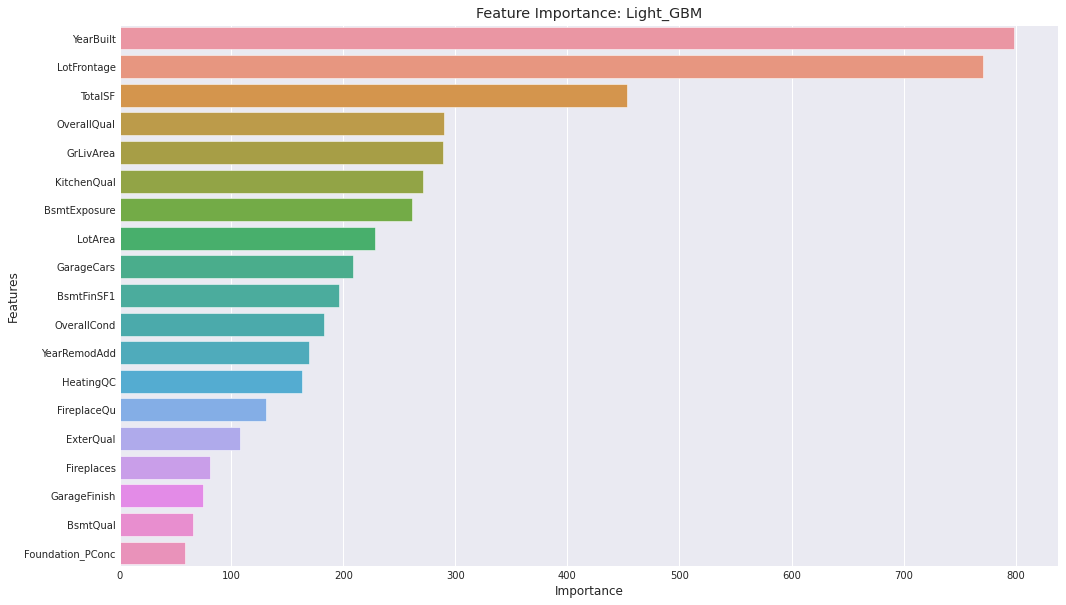

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


XGBoost score => RMSE: 0.0185, std: 0.0


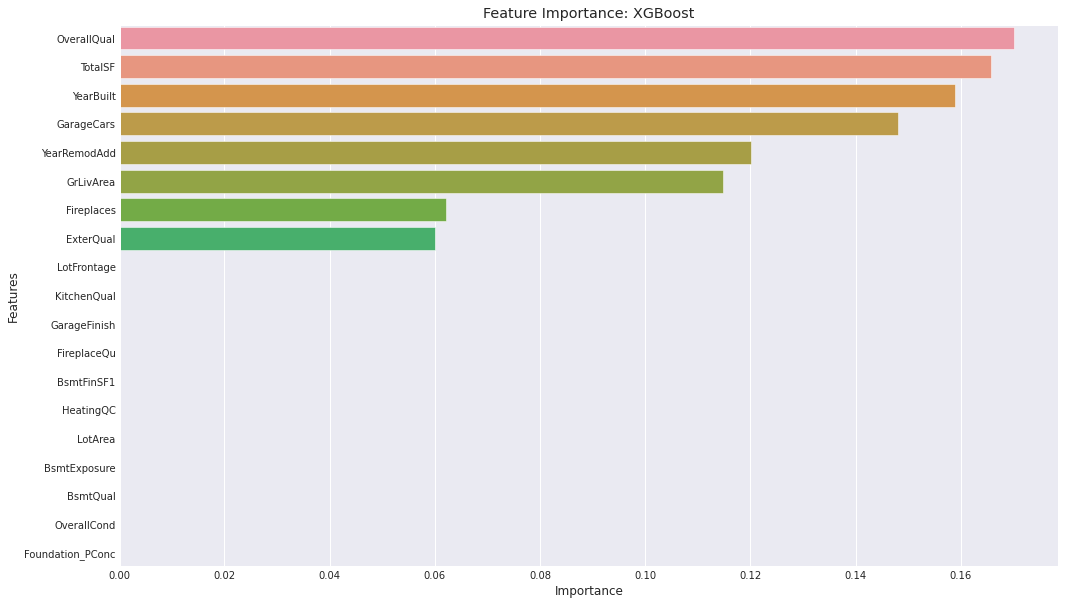

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Gradient_boosting score => RMSE: 0.0097, std: 0.0


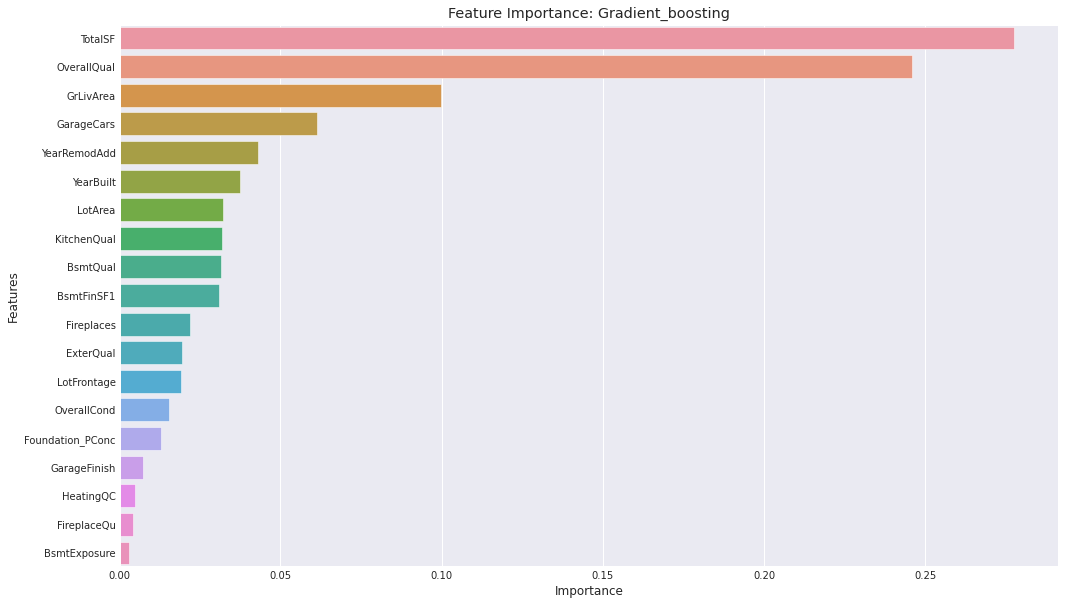

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Extra_trees score => RMSE: 0.0263, std: 0.0001


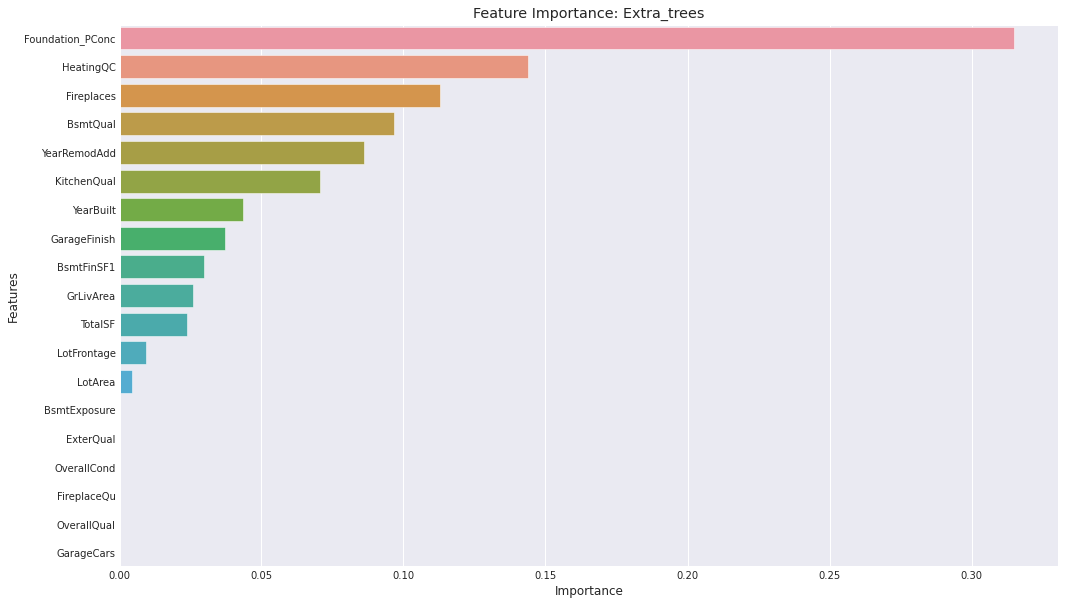

-------------------------------------------------------------------------------------------------

X => X_free_lasso, shape: (1458, 18)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_h

<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Light_GBM score => RMSE: 0.0098, std: 0.0


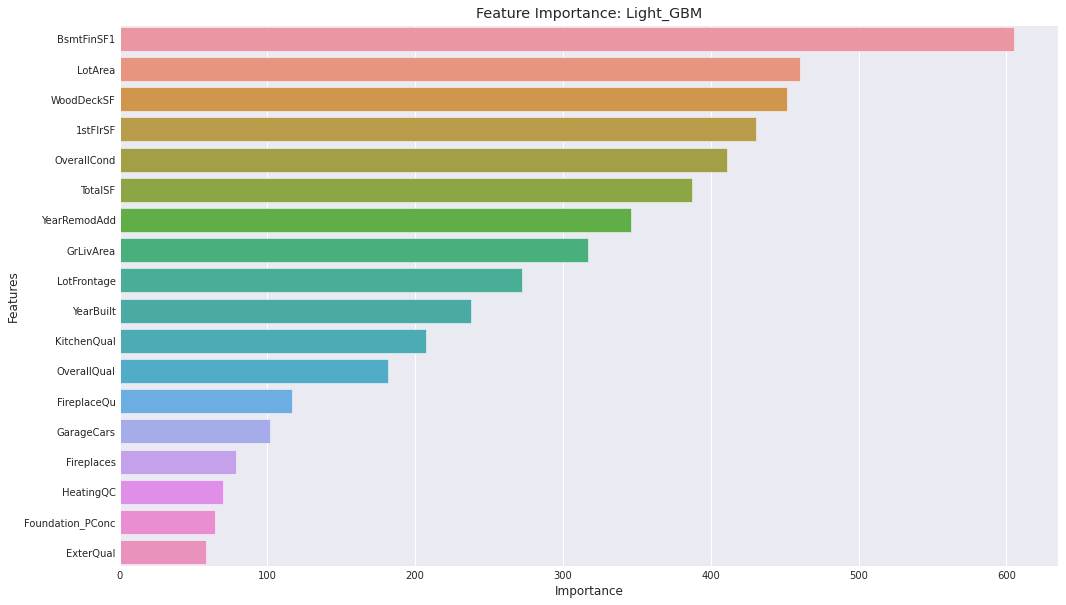

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


XGBoost score => RMSE: 0.0184, std: 0.0


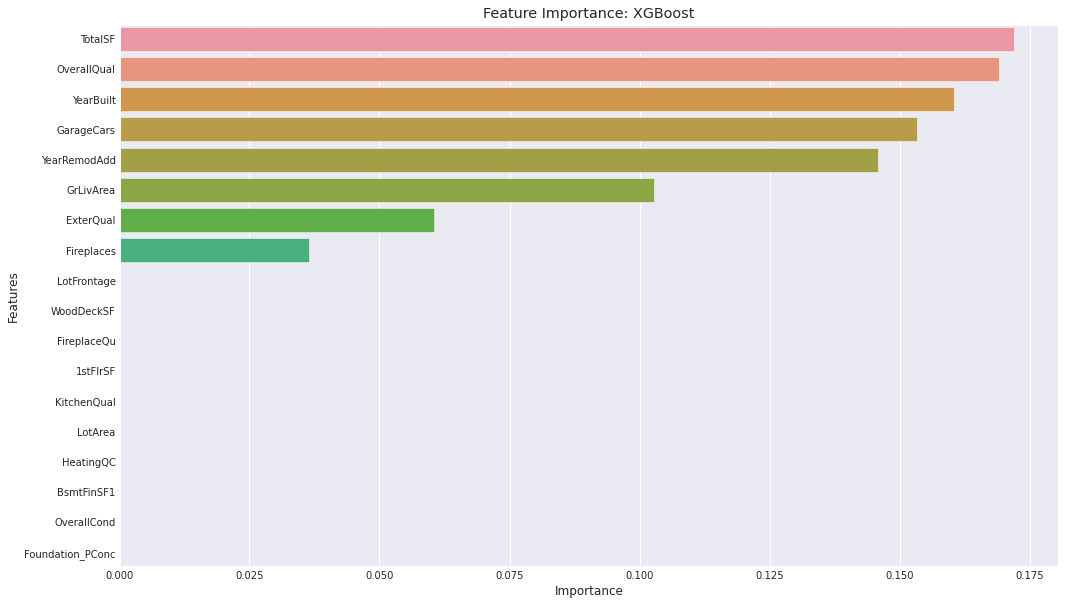

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Gradient_boosting score => RMSE: 0.0098, std: 0.0


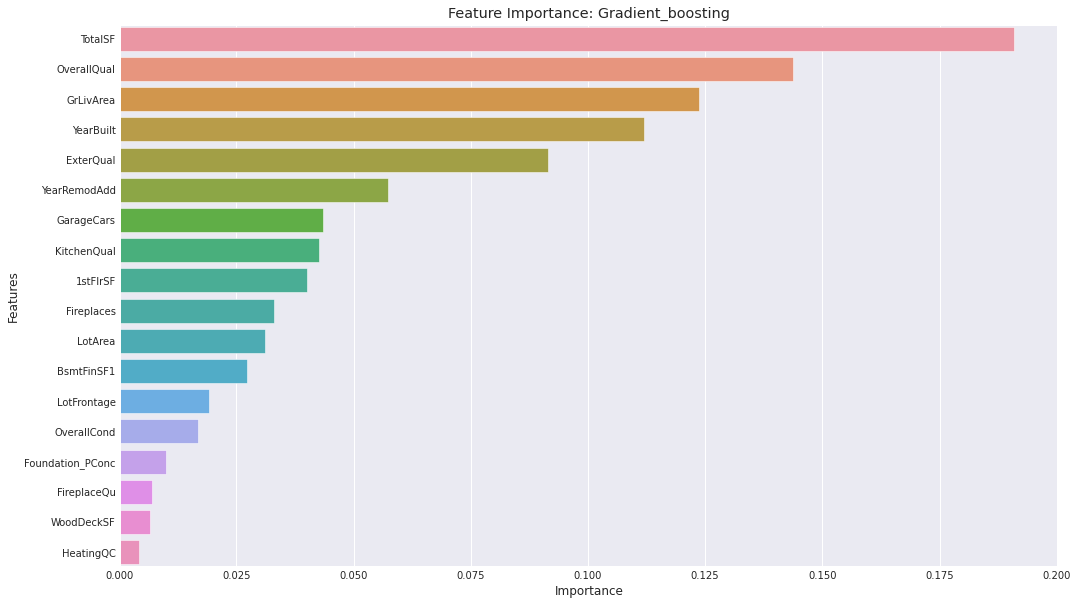

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Extra_trees score => RMSE: 0.0262, std: 0.0001


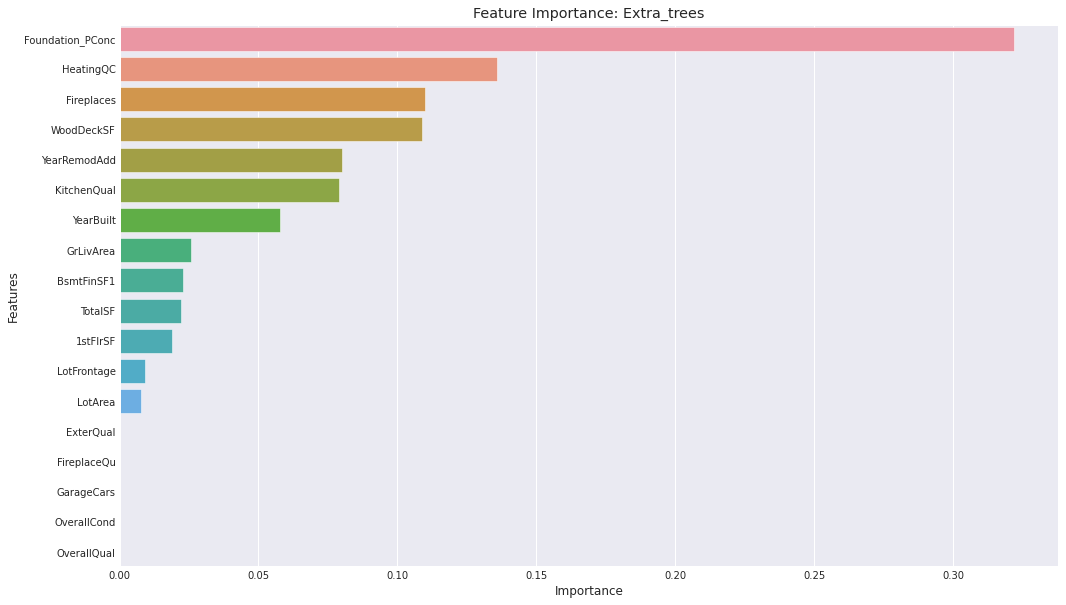

-------------------------------------------------------------------------------------------------

X => X_cat, shape: (1458, 206)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian

<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Light_GBM score => RMSE: 0.0091, std: 0.0


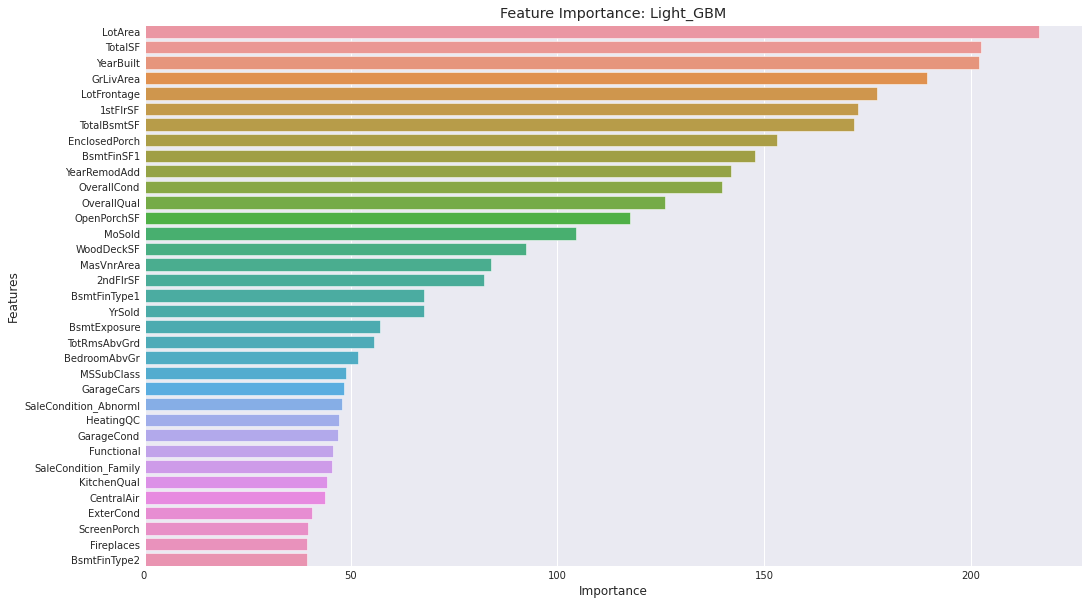

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


XGBoost score => RMSE: 0.0184, std: 0.0001


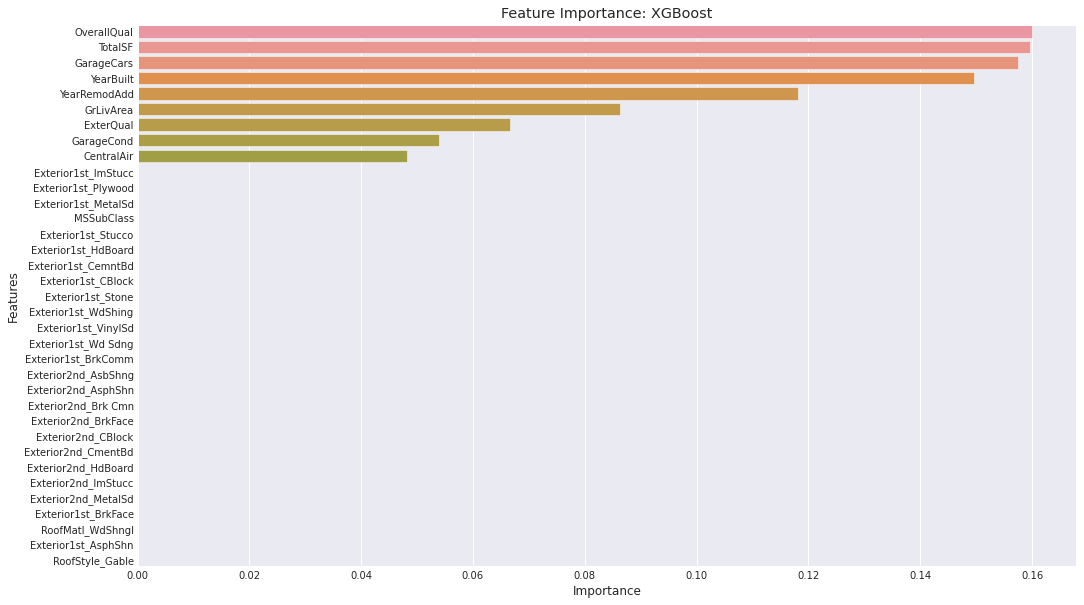

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Gradient_boosting score => RMSE: 0.0092, std: 0.0


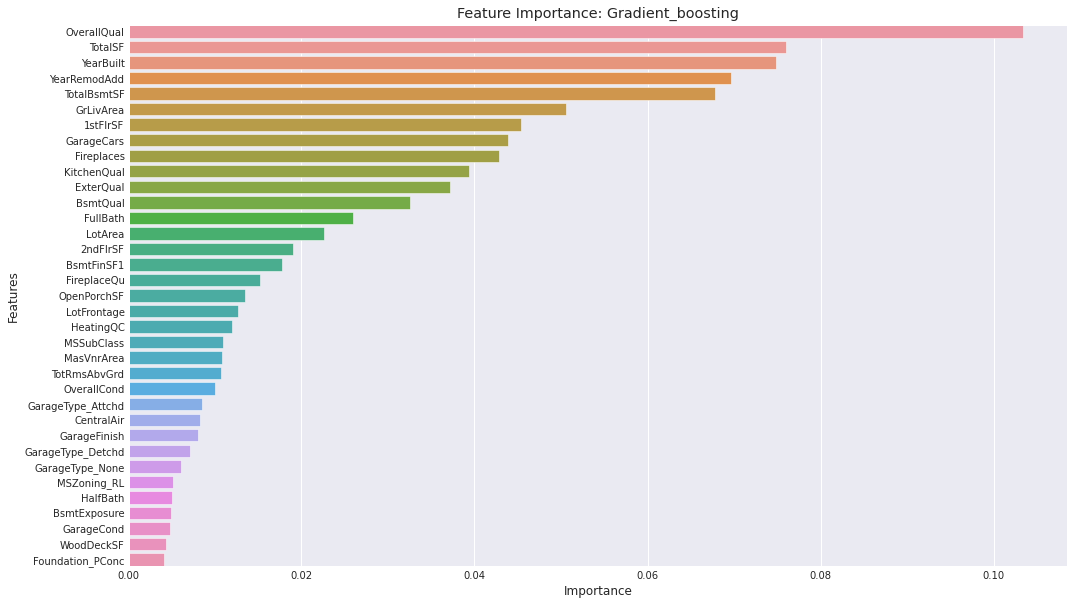

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Extra_trees score => RMSE: 0.0278, std: 0.0001


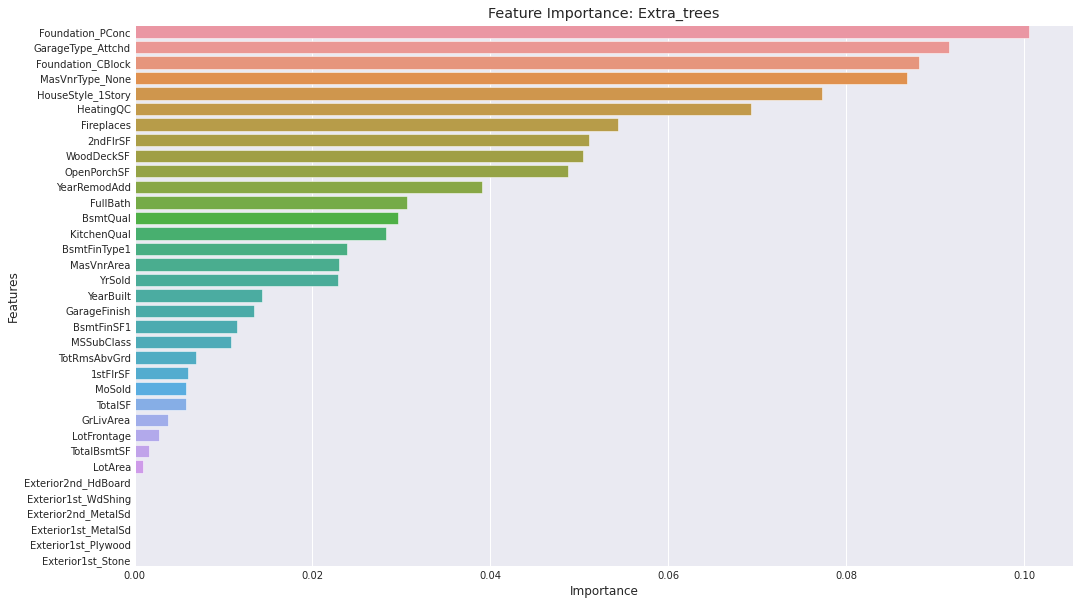

-------------------------------------------------------------------------------------------------

X => X_free, shape: (1458, 191)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Light_GBM score => RMSE: 0.009, std: 0.0


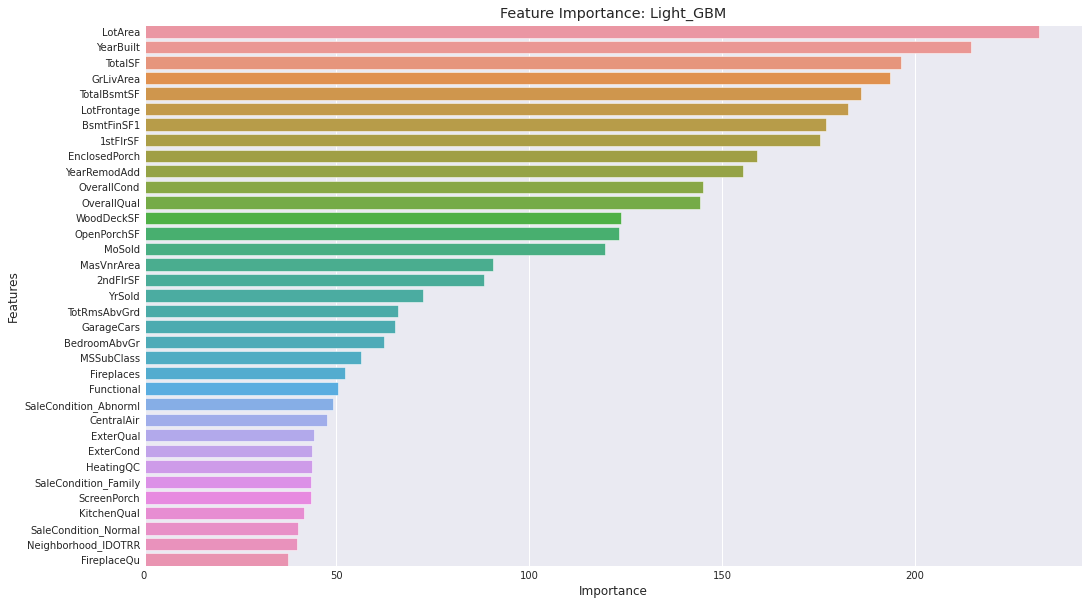

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


XGBoost score => RMSE: 0.0184, std: 0.0001


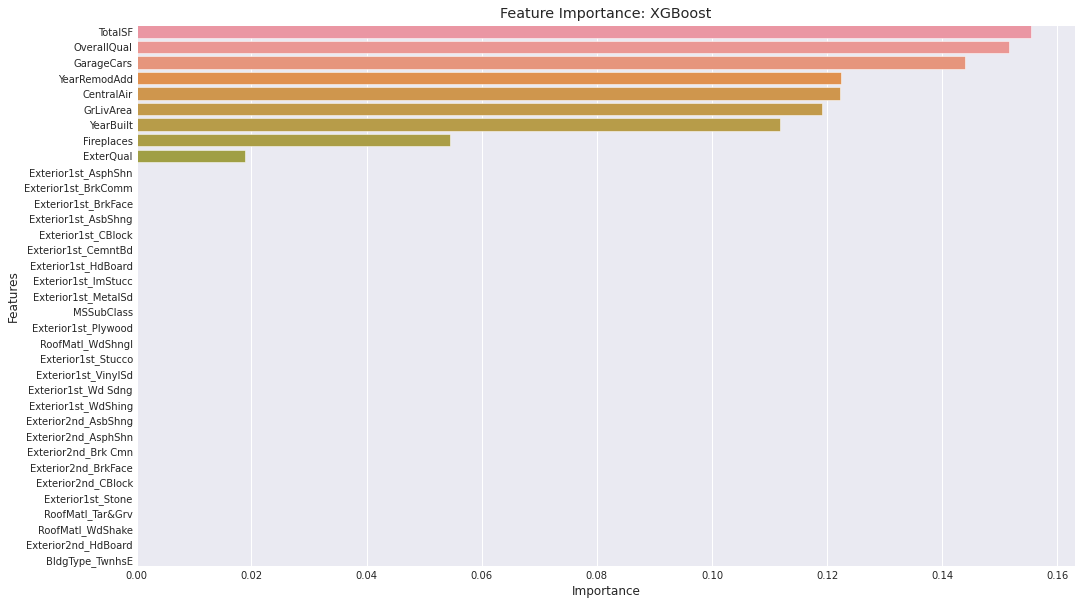

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Gradient_boosting score => RMSE: 0.0092, std: 0.0


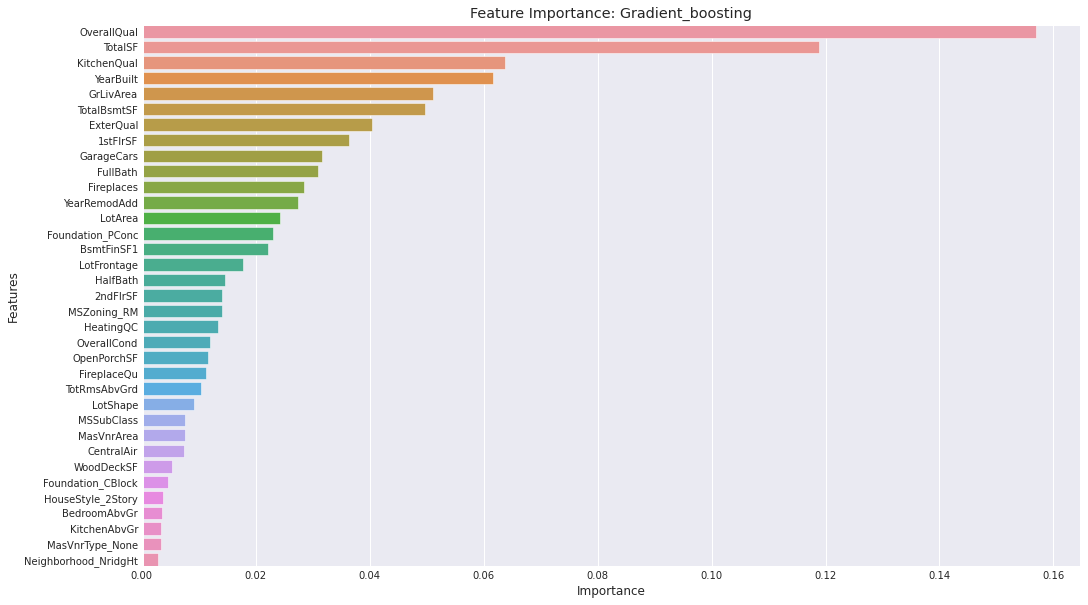

-------------------------------------------------------------------------------------------------


<ipython-input-60-ef131844255b>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feat_scores['Importance'] = feat_scores.mean(axis=1)


Extra_trees score => RMSE: 0.0281, std: 0.0001


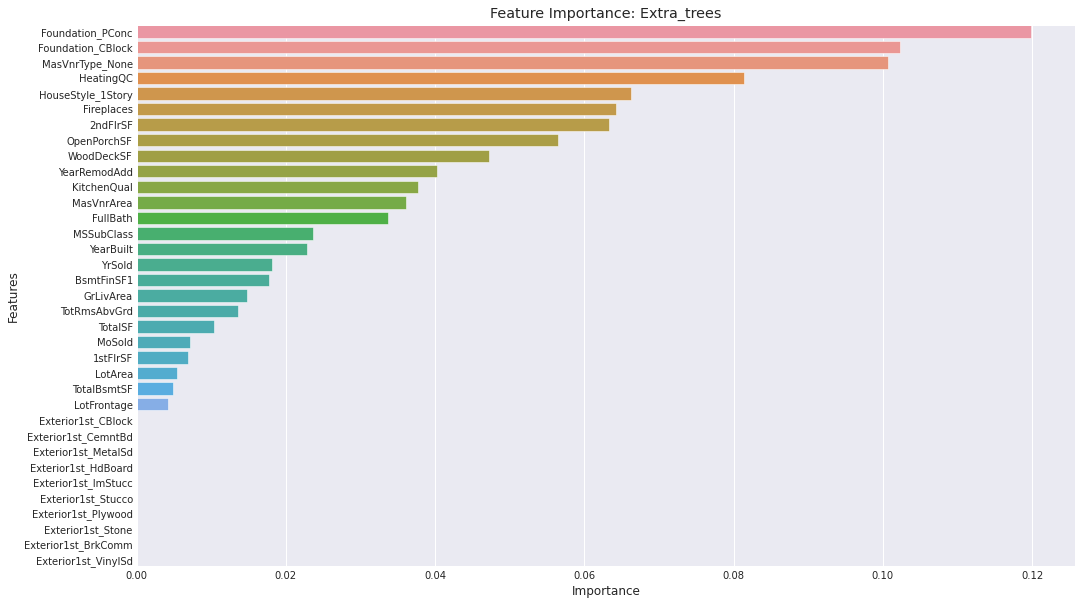

-------------------------------------------------------------------------------------------------



In [ ]:
print("Running boosting tree on X_cat_lasso, X_cat_free, X_cat, X_free")

training_data = {
    "X_cat_lasso": X_cat_lasso, "X_free_lasso": X_free_lasso,
    "X_cat": X_cat, "X_free": X_free, 
}


for X_name, X in training_data.items():
    print(f"X => {X_name}, shape: {X.shape}\n")
    for model_name, model in tree_models.items():
        fit_model(model_name, model, X, y, n_folds=7, show=35)
    print()

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

level0 = list()
# level0.extend(('LGB', tree_models["Light_GBM"]))
level0.append(('xgb', tree_models["XGBoost"]))
level0.append(('GBT', tree_models["Gradient_boosting"]))
level0.append(('xtra', tree_models["Extra_trees"]))

training_data = {"X_cat_lasso": X_cat_lasso, "X_free_lasso": X_free_lasso,
                 "X_cat": X_cat, "X_free": X_free, 
                 }


level1_models = {
    "Linear": LinearRegression(), 
}

In [ ]:
model_ = StackingRegressor(estimators=level0, final_estimator=level1_models['Linear'], cv=7, n_jobs=-1)
model_.fit(X_cat_lasso, y)
y_preds = model_.predict(X_cat_lasso)
print(f"Model: Linear, R2: {r2_score(y_preds, y)}, RMSE: {rmsle(y_preds, y)}")

Model: Linear, R2: 0.9861143247666425, RMSE: 0.003583420055302732


In [ ]:
model_ = StackingRegressor(estimators=level0, final_estimator=level1_models['Linear'], cv=7, n_jobs=-1)
model_.fit(X_cat_lasso, y)
y_preds = model_.predict(X_cat_lasso)
print(f"Model: Linear, R2: {r2_score(y_preds, y)}, RMSE: {rmsle(y_preds, y)}")

Model: Linear, R2: 0.9861143247666425, RMSE: 0.003583420055302733
